In [1]:
import os
import pandas as pd
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.saving import register_keras_serializable

In [2]:
train_path = r'../dataset/train'
test_path = r'../dataset/test'
valid_path = r'../dataset/val'
working_dir = r'./' 
list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [3]:
classes = os.listdir(train_path)
class_count = len(classes)
for cls in classes:
    class_path = os.path.join(train_path, cls)
    file_count = len(os.listdir(class_path))
    print('Class' , cls, ':', file_count)

Class 0 : 2286
Class 1 : 1046
Class 2 : 1516
Class 3 : 757
Class 4 : 173


## Učitavanje i balansiranje skupa podataka

In [4]:
def load_data(train_path, test_path, valid_path):
    for d in [train_path, test_path, valid_path]:
        file_paths = []
        labels = [] 
        class_list = os.listdir(d)   
        for cls in class_list:
            label = list_of_classes[int(cls)]
            class_path = os.path.join(d, cls)
            flist = os.listdir(class_path)        
            for f in flist:
                fpath = os.path.join(class_path, f)
                file_paths.append(fpath)
                labels.append(label)
        df = pd.DataFrame({
            'filepath': file_paths,
            'label': labels
        })

        if d == test_path:
            test_df = df
        elif d == valid_path:
            valid_df = df
        else:
            train_df = df
    print('train_df:', len(train_df), '\ntest_df:', len(test_df), '\nvalid_df:', len(valid_df))
    return train_df, test_df, valid_df

In [5]:
train_df, test_df, valid_df = load_data(train_path, test_path, valid_path)

train_df: 5778 
test_df: 1656 
valid_df: 826


In [6]:
train_df['label'].value_counts()

label
Healthy     2286
Minimal     1516
Doubtful    1046
Moderate     757
Severe       173
Name: count, dtype: int64

In [7]:
valid_df['label'].value_counts()

label
Healthy     328
Minimal     212
Doubtful    153
Moderate    106
Severe       27
Name: count, dtype: int64

In [8]:
max_train_samples = 500
max_valid_samples = 150

In [9]:
def augment(df, n, aug_dir, img_size):
    print('Initial length of dataframe is ', len(df))
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['label'].unique():    
        dir_path = os.path.join(aug_dir, label)    
        os.mkdir(dir_path)

    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups = df.groupby('label')
    for label in df['label'].unique():           
        group = groups.get_group(label)
        sample_count = len(group)  
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            aug_gen = gen.flow_from_dataframe(group, x_col='filepath', y_col=None, target_size=(img_size, img_size),
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count < delta:
                images = next(aug_gen)            
                aug_img_count += len(images)
            total += aug_img_count
    print('Total augmented images created = ', total)

In [ ]:
augment(train_df, max_train_samples, os.path.join(working_dir, 'train_aug'), 224)
augment(valid_df, max_valid_samples, os.path.join(working_dir, 'val_aug'), 224)

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total augmented images created =  327
Length of augmented dataframe is now  2500
Initial length of dataframe is  826
Found 106 validated image filenames.
Found 27 validated image filenames.
Total augmented images created =  167
Length of augmented dataframe is now  993


In [10]:
def trim(df, max_samples, column):
    groups = df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups = df.groupby(column)
    for label in df[column].unique(): 
        group = groups.get_group(label)
        count = len(group)    
        if count > max_samples:
            sampled_group = group.sample(n=max_samples, random_state=123, axis=0)
            trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            sampled_group = group        
            trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
    return trimmed_df

In [11]:
train_df = trim(train_df, max_train_samples, 'label')
valid_df = trim(valid_df, max_valid_samples, 'label')

In [12]:
def load_aug(df, aug_dir):
    aug_fpaths = []
    aug_labels = []
    classlist = os.listdir(aug_dir)
    for cls in classlist:
        class_path = os.path.join(aug_dir, cls)     
        flist = os.listdir(class_path)    
        for f in flist:        
            fpath = os.path.join(class_path, f)         
            aug_fpaths.append(fpath)
            aug_labels.append(cls)
    aug_df = pd.DataFrame({
        'filepath': aug_fpaths,
        'label': aug_labels
    })         
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    return df 

In [13]:
train_df = load_aug(train_df, './train_aug')
valid_df = load_aug(valid_df, './val_aug')

In [14]:
train_df['label'].value_counts()

label
Healthy     500
Doubtful    500
Minimal     500
Moderate    500
Severe      500
Name: count, dtype: int64

In [15]:
valid_df['label'].value_counts()

label
Healthy     150
Doubtful    150
Minimal     150
Moderate    150
Severe      150
Name: count, dtype: int64

In [16]:
def show_images(df):
    sampled_df = df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)

    plt.figure(figsize=(20, 20))

    for i, row in sampled_df.iterrows():
        path = row['filepath']
        label = row['label']

        image = Image.open(path)
        image = image.convert("RGB")

        plt.subplot(5, 5, i+1)
        plt.imshow(image)
        plt.title(label, color='blue', fontsize=14)
        plt.axis('off')

    plt.show()

C:\Users\Dositej 14\AppData\Local\Temp\ipykernel_13784\1323024817.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)


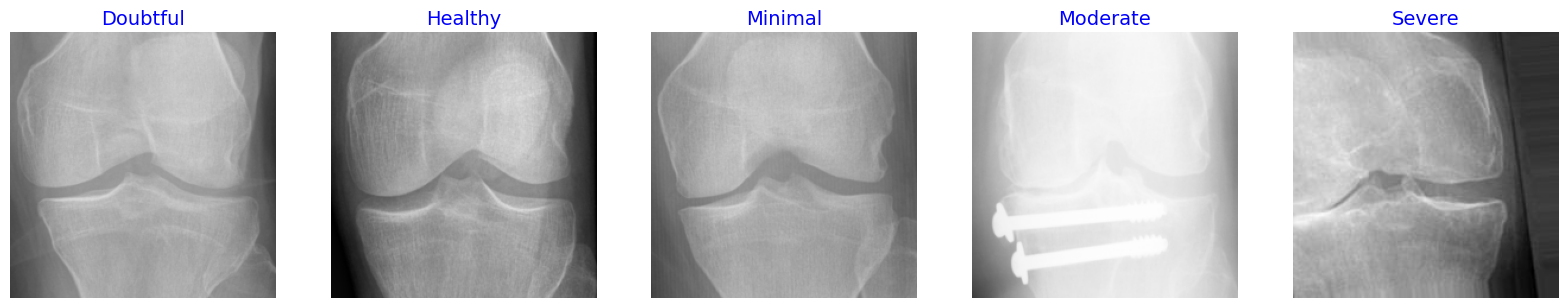

In [17]:
show_images(train_df)

## Treniranje modela

In [18]:
dict = {
    'Healthy': 0,
    'Doubtful': 1,
    'Minimal': 2,
    'Moderate': 3,
    'Severe': 4
}

train_df['label'] = train_df['label'].map(dict.get)
valid_df['label'] = valid_df['label'].map(dict.get)
test_df['label'] = test_df['label'].map(dict.get)

In [19]:
def prepare_data(df, img_size):
    x = np.zeros((len(df), img_size, img_size, 3), np.uint8)
    y = np.zeros((len(df), 1), np.uint8)

    for i, row in df.iterrows():
        path = row['filepath']
        label = row['label']
        img = cv2.imread(path)
        cy = img.shape[0]
        cx = img.shape[1]
        if cx > cy:
            d = cx - cy
            img = cv2.copyMakeBorder(img, top=d//2, bottom=d-d//2, left=0, right=0,
                                    borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
        else:
            d = cy - cx
            img = cv2.copyMakeBorder(img, top=0, bottom=0, left=d//2, right=d-d//2,
                                    borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
        img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
        x[i] = img
        y[i] = label

    rand_train_idx = np.random.RandomState(seed=0).permutation(len(df))
    x = x[rand_train_idx]
    y = y[rand_train_idx]

    return x, y

In [20]:
def create_callbacks(tmp_folder, path):
    save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_loss', mode='min',
                                                verbose=1, save_best_only=True)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                    patience=7, restore_best_weights=True, verbose=1)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min',
                                                    factor=0.1, patience=3, verbose=1)

    csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(tmp_folder, 'training.csv'))

    return [save_model, early_stopping, reduce_lr, csv_logger]

In [21]:
def plot_history(history):
    plt.clf()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

    plt.clf()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.show()

In [22]:
def evaluate(model, batch_size, x_test, y_test, classes):
    preds = model.predict(x_test, verbose=1, batch_size=batch_size)
    preds = np.argmax(preds, axis=1)
    
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(len(classes))+.5, classes, rotation=90)
    plt.yticks(np.arange(len(classes))+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    clr = classification_report(y_test, preds, target_names=classes, digits= 4)
    print("Classification Report:\n----------------------\n", clr)

In [23]:
root_folder = '../'

In [24]:
batch_size = 16
epochs = 30
lr = .001

### ResNet50V2 - 5 klasa

In [25]:
img_size = 224

In [26]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [27]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [28]:
tmp_folder = os.path.join(root_folder, 'ResNet50V2_5class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [29]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [70]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None, shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3037 - loss: 5.3542
Epoch 1: val_loss improved from inf to 3.28716, saving model to ../ResNet50V2_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.3040 - loss: 5.3494 - val_accuracy: 0.4267 - val_loss: 3.2872 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4513 - loss: 2.9692
Epoch 2: val_loss improved from 3.28716 to 2.77901, saving model to ../ResNet50V2_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.4513 - loss: 2.9685 - val_accuracy: 0.4560 - val_loss: 2.7790 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4674 - loss: 2.5822
Epoch 3: val_loss did not improve from 2.77901
157/157 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.4674 - loss: 2.5812 - val_accuracy: 0.4227 - val_loss: 3.2054 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accur

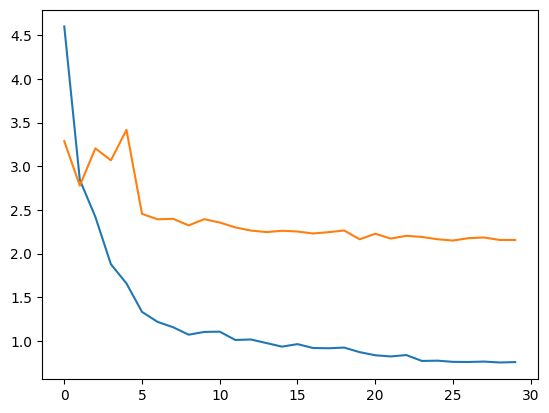

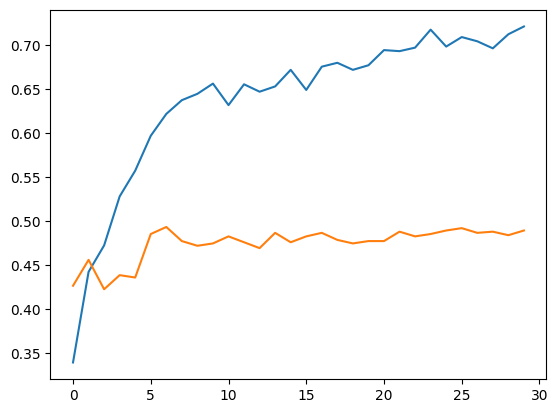

In [71]:
plot_history(history)

104/104 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step


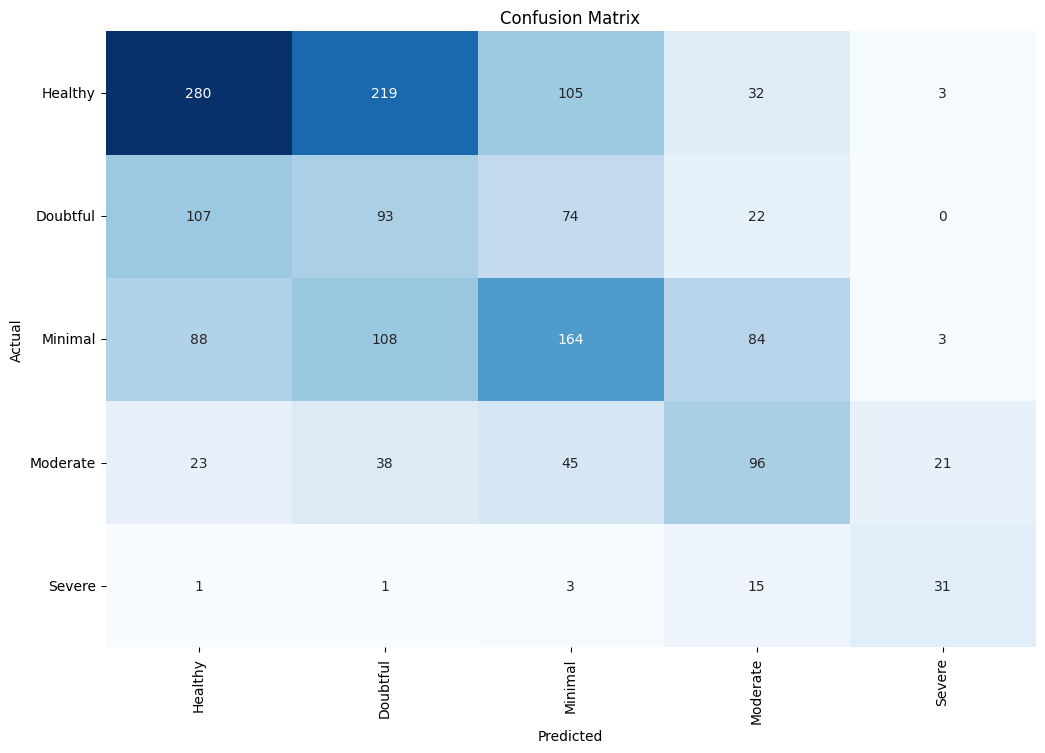

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.5611    0.4382    0.4921       639
    Doubtful     0.2026    0.3142    0.2464       296
     Minimal     0.4194    0.3669    0.3914       447
    Moderate     0.3855    0.4305    0.4068       223
      Severe     0.5345    0.6078    0.5688        51

    accuracy                         0.4010      1656
   macro avg     0.4206    0.4315    0.4211      1656
weighted avg     0.4343    0.4010    0.4119      1656



In [31]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

#### Full

In [32]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [33]:
tmp_folder = os.path.join(root_folder, 'ResNet50V2_5class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [34]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [115]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2671 - loss: 4.3839
Epoch 1: val_loss improved from inf to 1101.26807, saving model to ../ResNet50V2_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 1069s 7s/step - accuracy: 0.2672 - loss: 4.3753 - val_accuracy: 0.2053 - val_loss: 1101.2681 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3039 - loss: 2.7469
Epoch 2: val_loss improved from 1101.26807 to 119.25533, saving model to ../ResNet50V2_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 956s 6s/step - accuracy: 0.3038 - loss: 2.7458 - val_accuracy: 0.2693 - val_loss: 119.2553 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3092 - loss: 2.1468
Epoch 3: val_loss did not improve from 119.25533
157/157 ━━━━━━━━━━━━━━━━━━━━ 934s 6s/step - accuracy: 0.3091 - loss: 2.1480 - val_accuracy: 0.1933 - val_loss: 582.9180 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/

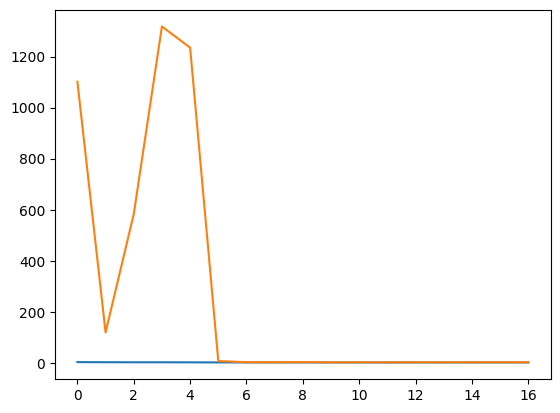

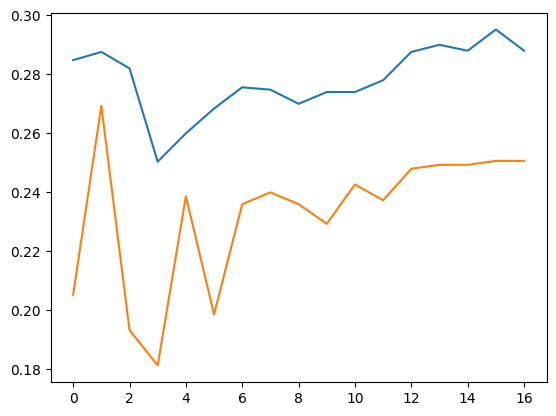

In [116]:
plot_history(history)

104/104 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step


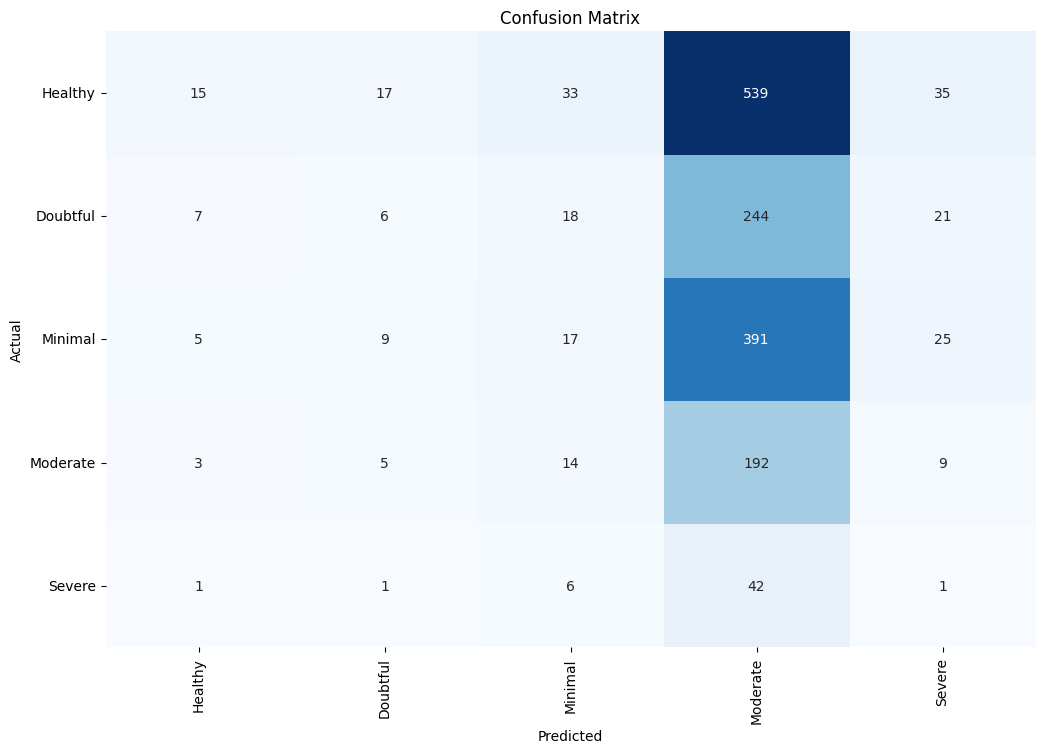

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.4839    0.0235    0.0448       639
    Doubtful     0.1579    0.0203    0.0359       296
     Minimal     0.1932    0.0380    0.0636       447
    Moderate     0.1364    0.8610    0.2354       223
      Severe     0.0110    0.0196    0.0141        51

    accuracy                         0.1395      1656
   macro avg     0.1965    0.1925    0.0788      1656
weighted avg     0.2858    0.1395    0.0730      1656



In [36]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

### EfficientNetB2 - 5 klasa

In [25]:
img_size = 260

In [26]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [135]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [136]:
tmp_folder = os.path.join(root_folder, 'EfficientNetB2_5class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [137]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [138]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2574 - loss: 4.8378
Epoch 1: val_loss improved from inf to 2.67906, saving model to ../EfficientNetB2_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.2576 - loss: 4.8333 - val_accuracy: 0.3960 - val_loss: 2.6791 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3382 - loss: 3.6192
Epoch 2: val_loss improved from 2.67906 to 2.40571, saving model to ../EfficientNetB2_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.3383 - loss: 3.6174 - val_accuracy: 0.4027 - val_loss: 2.4057 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3759 - loss: 2.7982
Epoch 3: val_loss improved from 2.40571 to 1.97269, saving model to ../EfficientNetB2_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.3759 - loss: 2.7983 - val_accuracy: 0.4133 - val_loss: 1.9727 - learni

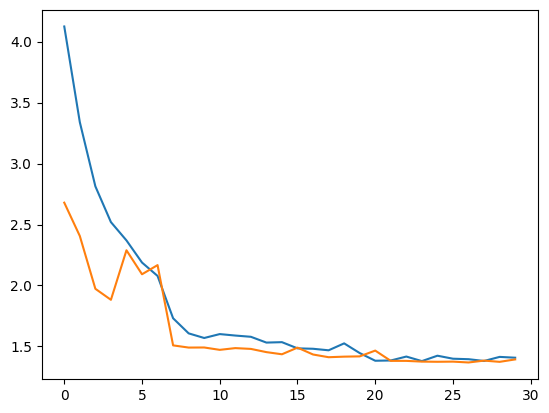

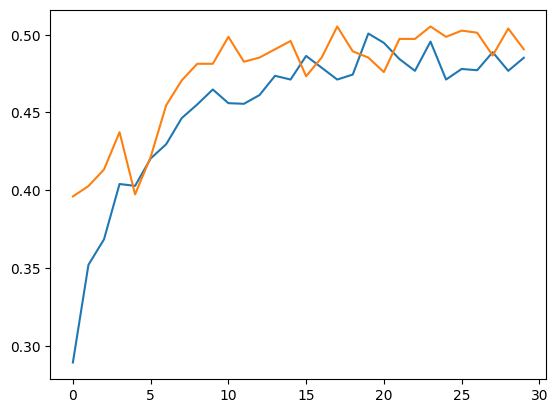

In [139]:
plot_history(history)

104/104 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step


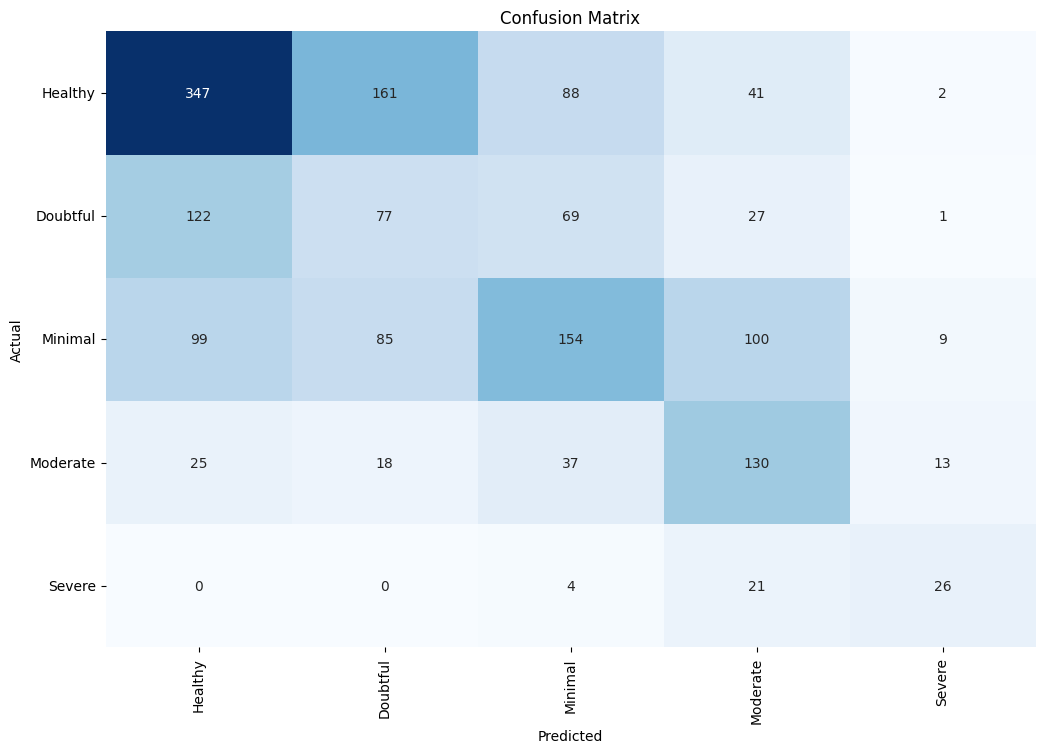

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.5852    0.5430    0.5633       639
    Doubtful     0.2258    0.2601    0.2418       296
     Minimal     0.4375    0.3445    0.3855       447
    Moderate     0.4075    0.5830    0.4797       223
      Severe     0.5098    0.5098    0.5098        51

    accuracy                         0.4432      1656
   macro avg     0.4332    0.4481    0.4360      1656
weighted avg     0.4548    0.4432    0.4449      1656



In [140]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

#### Full

In [27]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [28]:
tmp_folder = os.path.join(root_folder, 'EfficientNetB2_5class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [29]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [30]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3760 - loss: 3.2593
Epoch 1: val_loss improved from inf to 1.75139, saving model to ../EfficientNetB2_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 1527s 9s/step - accuracy: 0.3763 - loss: 3.2519 - val_accuracy: 0.4840 - val_loss: 1.7514 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5669 - loss: 1.0357
Epoch 2: val_loss improved from 1.75139 to 1.54913, saving model to ../EfficientNetB2_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 1199s 8s/step - accuracy: 0.5670 - loss: 1.0354 - val_accuracy: 0.5213 - val_loss: 1.5491 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6514 - loss: 0.7887
Epoch 3: val_loss did not improve from 1.54913
157/157 ━━━━━━━━━━━━━━━━━━━━ 1177s 7s/step - accuracy: 0.6514 - loss: 0.7888 - val_accuracy: 0.5787 - val_loss: 1.6556 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - 

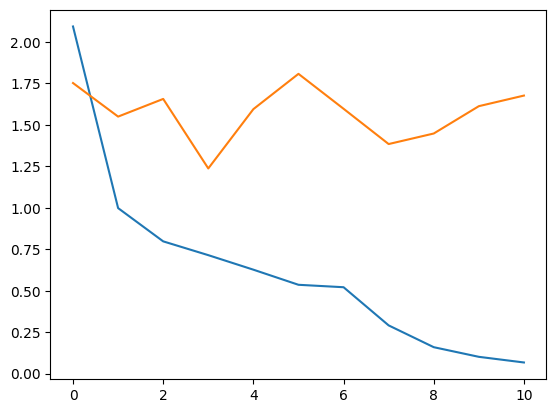

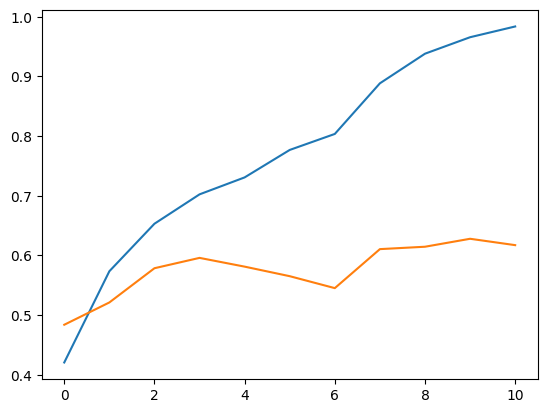

In [31]:
plot_history(history)

104/104 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step


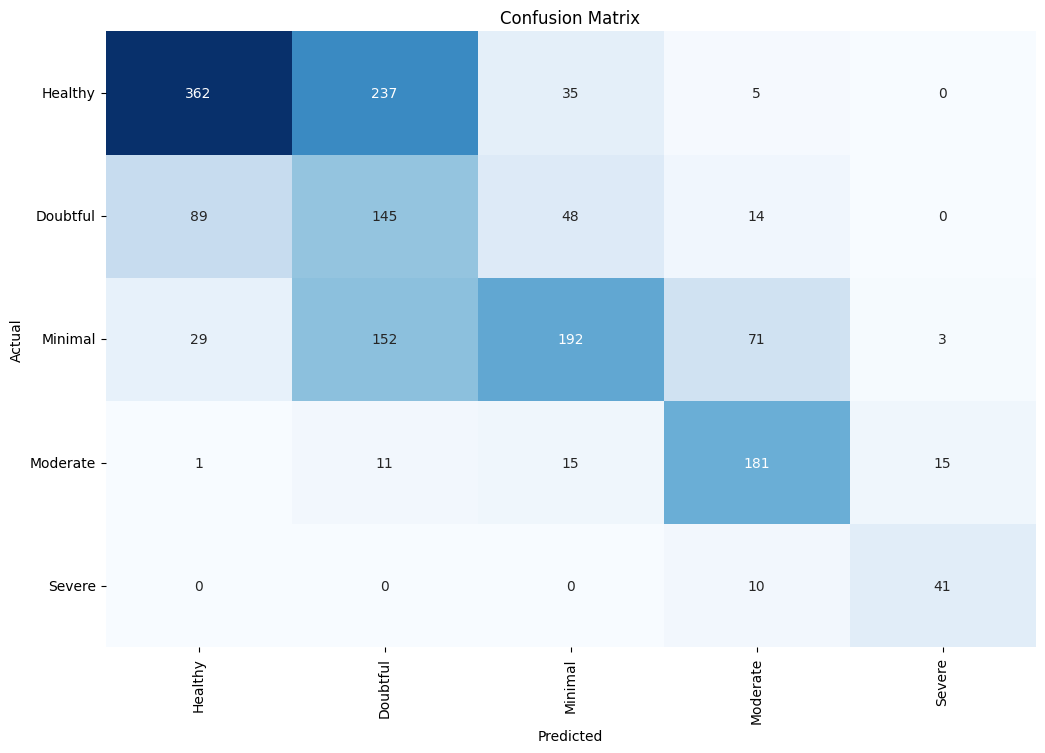

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.7526    0.5665    0.6464       639
    Doubtful     0.2661    0.4899    0.3448       296
     Minimal     0.6621    0.4295    0.5210       447
    Moderate     0.6441    0.8117    0.7183       223
      Severe     0.6949    0.8039    0.7455        51

    accuracy                         0.5562      1656
   macro avg     0.6040    0.6203    0.5952      1656
weighted avg     0.6248    0.5562    0.5714      1656



In [32]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

### NASNetMobile - 5 klasa

In [49]:
img_size = 224

In [50]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [51]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.nasnet.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [52]:
tmp_folder = os.path.join(root_folder, 'NASNetMobile_5class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [53]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [27]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.2616 - loss: 2.9842
Epoch 1: val_loss improved from inf to 1.89693, saving model to ../NASNetMobile_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 759ms/step - accuracy: 0.2619 - loss: 2.9822 - val_accuracy: 0.3973 - val_loss: 1.8969 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.3750 - loss: 2.1915
Epoch 2: val_loss did not improve from 1.89693
157/157 ━━━━━━━━━━━━━━━━━━━━ 111s 706ms/step - accuracy: 0.3750 - loss: 2.1916 - val_accuracy: 0.4227 - val_loss: 1.9994 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.4228 - loss: 1.9991
Epoch 3: val_loss improved from 1.89693 to 1.87882, saving model to ../NASNetMobile_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 114s 724ms/step - accuracy: 0.4227 - loss: 1.9987 - val_accuracy: 0.4253 - val_loss: 1.8788 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━

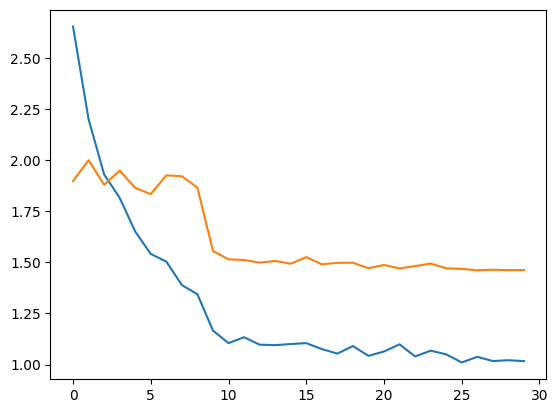

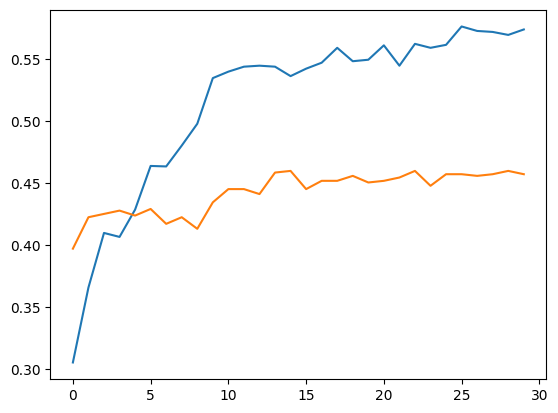

In [28]:
plot_history(history)

104/104 ━━━━━━━━━━━━━━━━━━━━ 98s 823ms/step


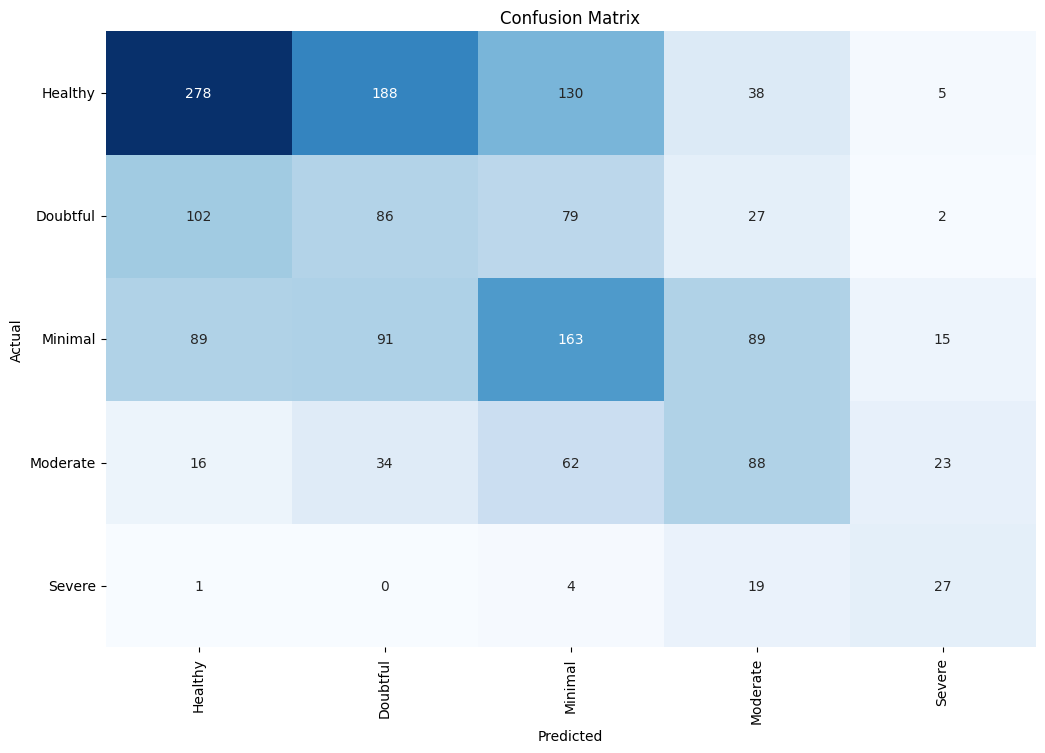

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.5720    0.4351    0.4942       639
    Doubtful     0.2155    0.2905    0.2475       296
     Minimal     0.3721    0.3647    0.3684       447
    Moderate     0.3372    0.3946    0.3636       223
      Severe     0.3750    0.5294    0.4390        51

    accuracy                         0.3877      1656
   macro avg     0.3744    0.4029    0.3825      1656
weighted avg     0.4167    0.3877    0.3969      1656



In [55]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

#### Full

In [56]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.nasnet.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [57]:
tmp_folder = os.path.join(root_folder, 'NASNetMobile_5class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [58]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [33]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3212 - loss: 2.9535
Epoch 1: val_loss improved from inf to 6.68705, saving model to ../NASNetMobile_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step - accuracy: 0.3216 - loss: 2.9465 - val_accuracy: 0.2240 - val_loss: 6.6870 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5452 - loss: 1.0421
Epoch 2: val_loss improved from 6.68705 to 1.77213, saving model to ../NASNetMobile_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.5454 - loss: 1.0417 - val_accuracy: 0.2867 - val_loss: 1.7721 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6263 - loss: 0.8454
Epoch 3: val_loss did not improve from 1.77213
157/157 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.6264 - loss: 0.8451 - val_accuracy: 0.3907 - val_loss: 2.2500 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accurac

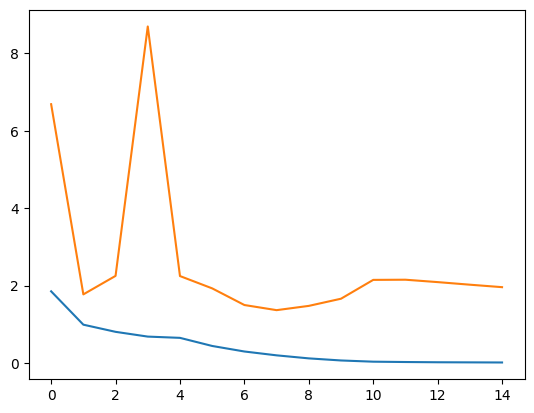

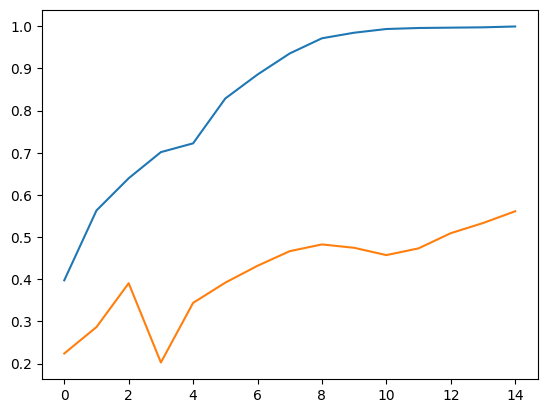

In [34]:
plot_history(history)

104/104 ━━━━━━━━━━━━━━━━━━━━ 98s 835ms/step


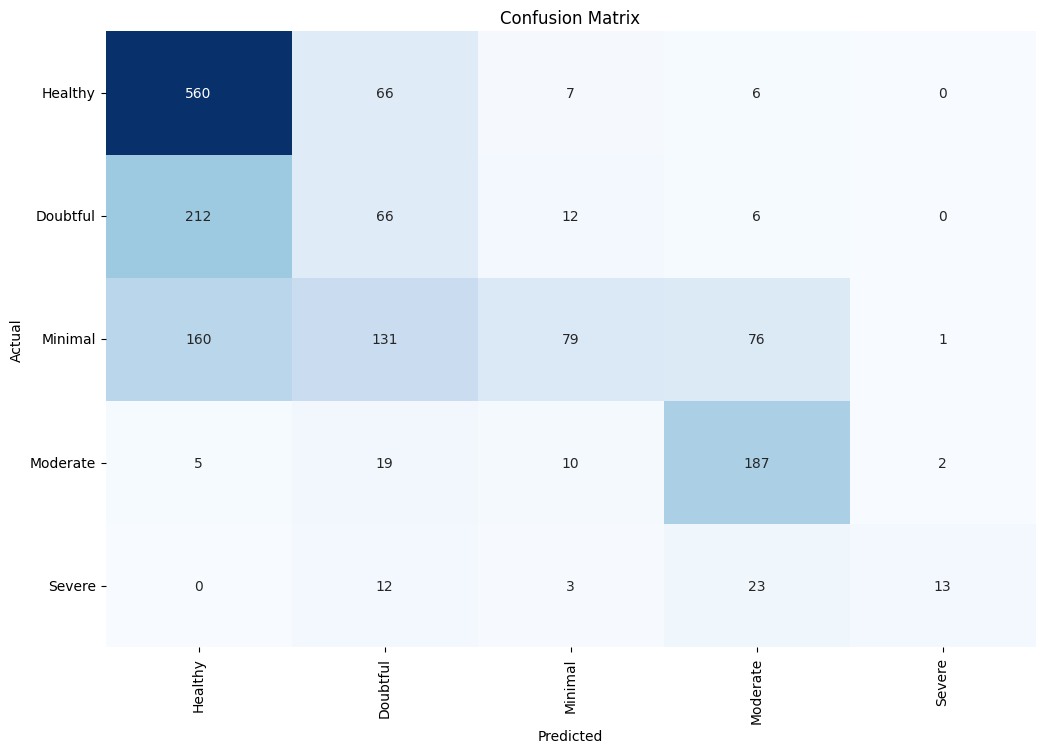

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.5977    0.8764    0.7107       639
    Doubtful     0.2245    0.2230    0.2237       296
     Minimal     0.7117    0.1767    0.2832       447
    Moderate     0.6275    0.8386    0.7179       223
      Severe     0.8125    0.2549    0.3881        51

    accuracy                         0.5465      1656
   macro avg     0.5948    0.4739    0.4647      1656
weighted avg     0.5724    0.5465    0.4993      1656



In [60]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

### XCeption - 5 klasa

In [61]:
img_size = 299

In [62]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [63]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.xception.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [64]:
tmp_folder = os.path.join(root_folder, 'XCeption_5class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [65]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [30]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3349 - loss: 1.7018
Epoch 1: val_loss improved from inf to 1.46973, saving model to ../XCeption_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 654s 4s/step - accuracy: 0.3353 - loss: 1.7008 - val_accuracy: 0.4187 - val_loss: 1.4697 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4618 - loss: 1.3056
Epoch 2: val_loss improved from 1.46973 to 1.46321, saving model to ../XCeption_5class_softmax\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 621s 4s/step - accuracy: 0.4617 - loss: 1.3057 - val_accuracy: 0.4280 - val_loss: 1.4632 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4975 - loss: 1.2267
Epoch 3: val_loss did not improve from 1.46321
157/157 ━━━━━━━━━━━━━━━━━━━━ 619s 4s/step - accuracy: 0.4975 - loss: 1.2268 - val_accuracy: 0.4600 - val_loss: 1.4792 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy:

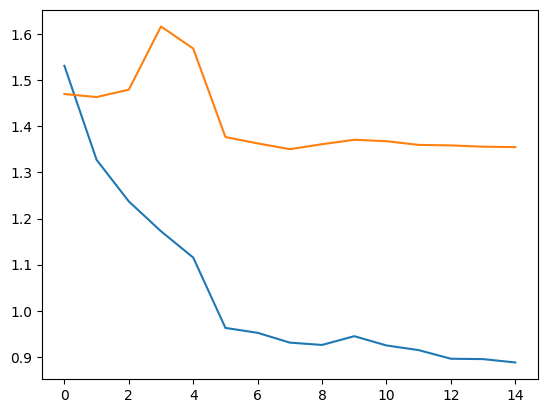

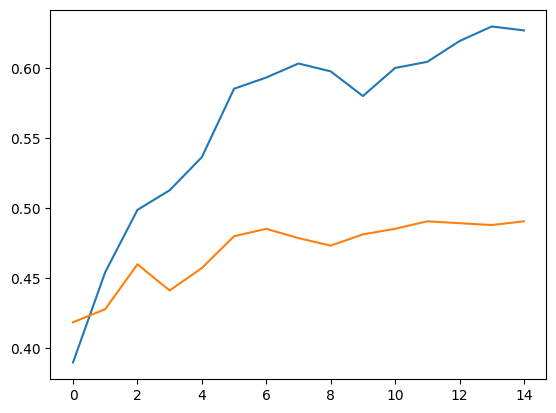

In [31]:
plot_history(history)

104/104 ━━━━━━━━━━━━━━━━━━━━ 441s 4s/step


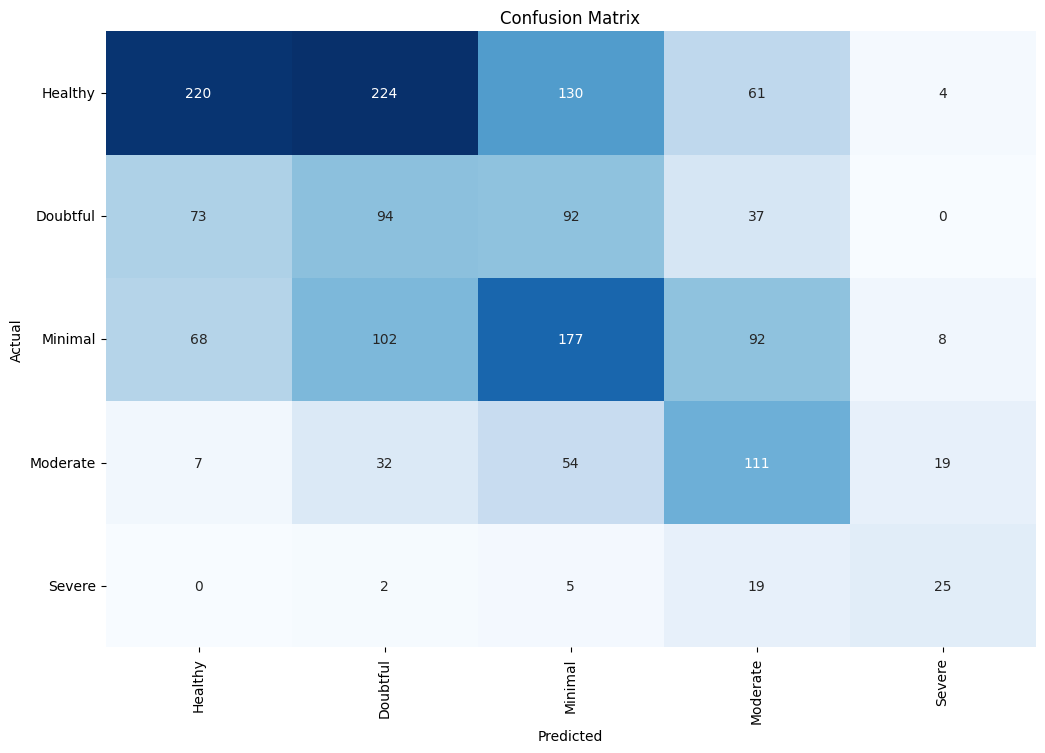

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.5978    0.3443    0.4369       639
    Doubtful     0.2070    0.3176    0.2507       296
     Minimal     0.3865    0.3960    0.3912       447
    Moderate     0.3469    0.4978    0.4088       223
      Severe     0.4464    0.4902    0.4673        51

    accuracy                         0.3786      1656
   macro avg     0.3969    0.4092    0.3910      1656
weighted avg     0.4325    0.3786    0.3884      1656



In [67]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

#### Full

In [68]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.xception.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [69]:
tmp_folder = os.path.join(root_folder, 'XCeption_5class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [70]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [27]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4109 - loss: 1.4113 
Epoch 1: val_loss improved from inf to 2.40673, saving model to ../XCeption_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 2756s 17s/step - accuracy: 0.4112 - loss: 1.4101 - val_accuracy: 0.4587 - val_loss: 2.4067 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5490 - loss: 1.0138 
Epoch 2: val_loss improved from 2.40673 to 1.26338, saving model to ../XCeption_5class_full\model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 2623s 17s/step - accuracy: 0.5491 - loss: 1.0134 - val_accuracy: 0.5427 - val_loss: 1.2634 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5977 - loss: 0.8649 
Epoch 3: val_loss did not improve from 1.26338
157/157 ━━━━━━━━━━━━━━━━━━━━ 2614s 17s/step - accuracy: 0.5979 - loss: 0.8647 - val_accuracy: 0.5093 - val_loss: 4.2029 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - ac

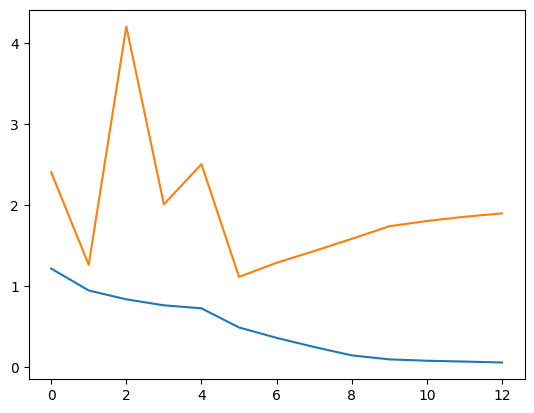

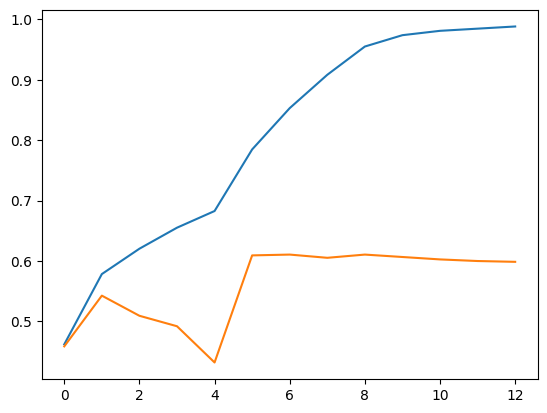

In [28]:
plot_history(history)

104/104 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step


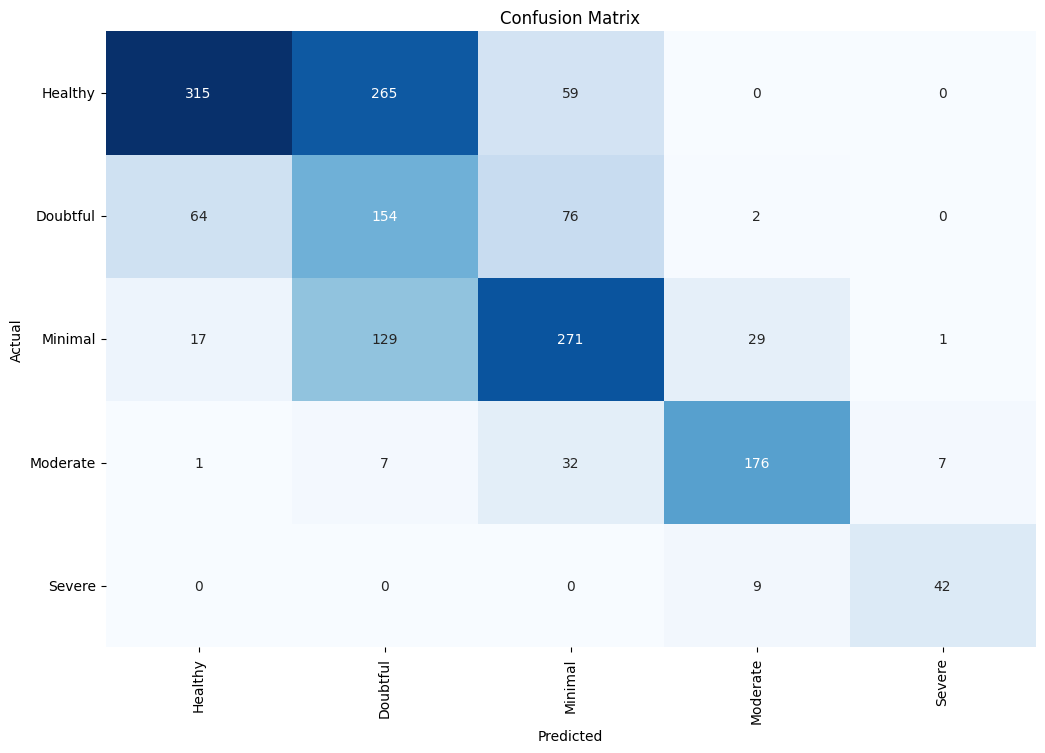

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.7935    0.4930    0.6081       639
    Doubtful     0.2775    0.5203    0.3619       296
     Minimal     0.6187    0.6063    0.6124       447
    Moderate     0.8148    0.7892    0.8018       223
      Severe     0.8400    0.8235    0.8317        51

    accuracy                         0.5785      1656
   macro avg     0.6689    0.6465    0.6432      1656
weighted avg     0.6584    0.5785    0.5982      1656



In [72]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

### TRI KLASE

In [33]:
drop_classes = [1, 2] # Doubtful and Minimal 
list_of_classes.remove('Doubtful')
list_of_classes.remove('Minimal')

train_df = train_df[~train_df['label'].isin(drop_classes)]
valid_df = valid_df[~valid_df['label'].isin(drop_classes)]  
test_df = test_df[~test_df['label'].isin(drop_classes)]

train_df = train_df.reset_index()
valid_df = valid_df.reset_index()
test_df = test_df.reset_index()

In [34]:
train_df['label'].value_counts()

label
0    500
3    500
4    500
Name: count, dtype: int64

In [35]:
test_df['label'].value_counts()

label
0    639
3    223
4     51
Name: count, dtype: int64

In [36]:
valid_df['label'].value_counts()

label
0    150
3    150
4    150
Name: count, dtype: int64

### EfficientNetB2 - 3 klase

In [37]:
img_size = 260

In [38]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [39]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [40]:
tmp_folder = os.path.join(root_folder, 'EfficientNetB2_3class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [41]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [42]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4062 - loss: 3.2664
Epoch 1: val_loss improved from inf to 1.13481, saving model to ../EfficientNetB2_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.4070 - loss: 3.2596 - val_accuracy: 0.5956 - val_loss: 1.1348 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6067 - loss: 1.5911
Epoch 2: val_loss did not improve from 1.13481
94/94 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.6066 - loss: 1.5922 - val_accuracy: 0.5644 - val_loss: 1.3308 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5916 - loss: 1.5958
Epoch 3: val_loss did not improve from 1.13481
94/94 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.5918 - loss: 1.5956 - val_accuracy: 0.5178 - val_loss: 1.7178 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6197 - loss: 1.8529
Epoch 4: val_loss did not improve from 1.1348

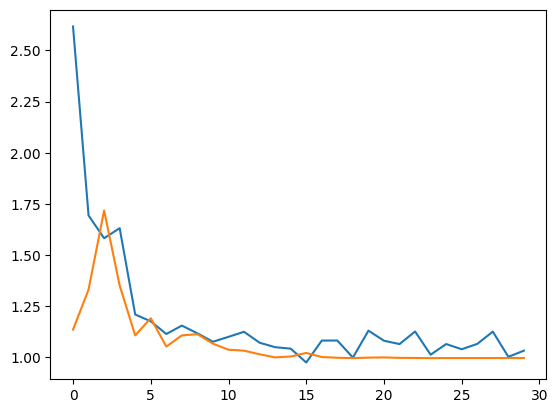

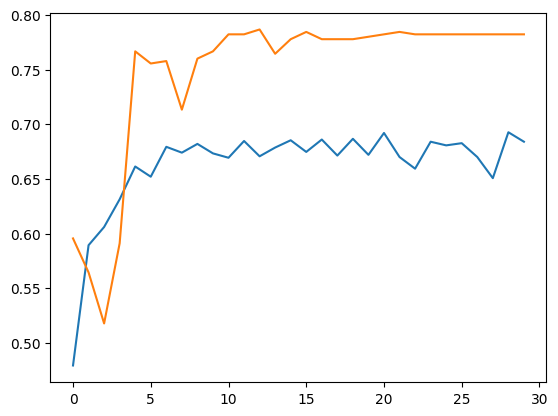

In [43]:
plot_history(history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step


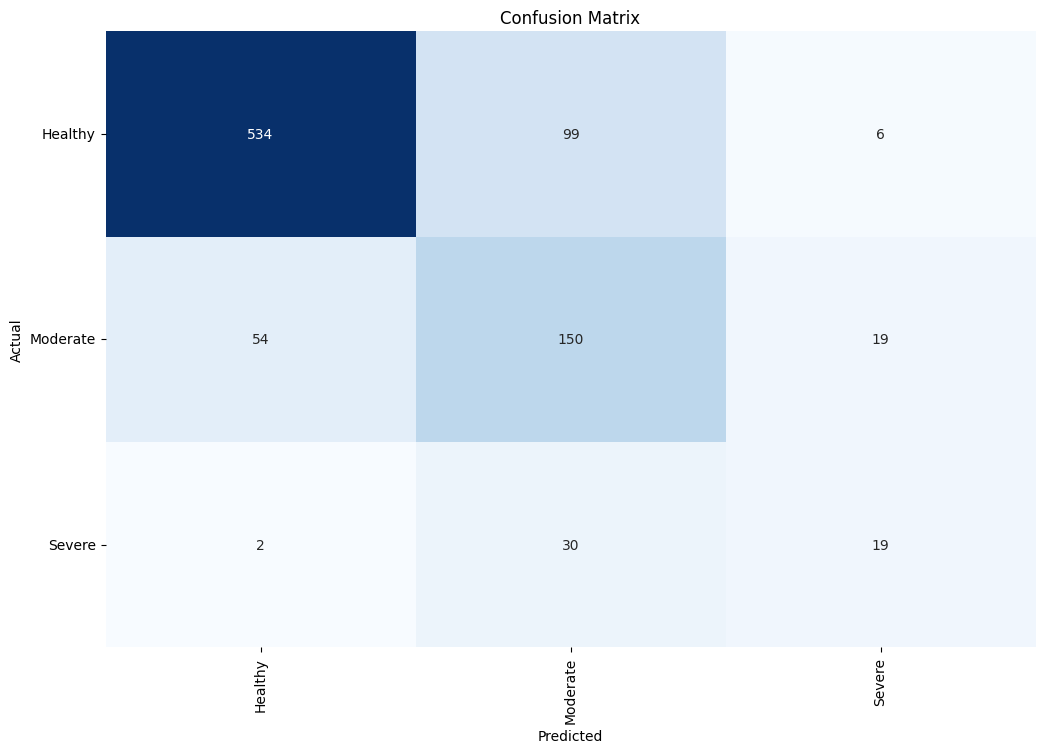

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9051    0.8357    0.8690       639
    Moderate     0.5376    0.6726    0.5976       223
      Severe     0.4318    0.3725    0.4000        51

    accuracy                         0.7700       913
   macro avg     0.6248    0.6270    0.6222       913
weighted avg     0.7889    0.7700    0.7765       913



In [44]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

#### Full

In [45]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [46]:
tmp_folder = os.path.join(root_folder, 'EfficientNetB2_3class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [47]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [48]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6214 - loss: 2.8041
Epoch 1: val_loss improved from inf to 4.78427, saving model to ../EfficientNetB2_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 912s 9s/step - accuracy: 0.6223 - loss: 2.7943 - val_accuracy: 0.6178 - val_loss: 4.7843 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8700 - loss: 0.5213
Epoch 2: val_loss did not improve from 4.78427
94/94 ━━━━━━━━━━━━━━━━━━━━ 723s 8s/step - accuracy: 0.8702 - loss: 0.5198 - val_accuracy: 0.6267 - val_loss: 6.0090 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9560 - loss: 0.1390
Epoch 3: val_loss improved from 4.78427 to 1.65364, saving model to ../EfficientNetB2_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 711s 8s/step - accuracy: 0.9560 - loss: 0.1392 - val_accuracy: 0.8200 - val_loss: 1.6536 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9387 

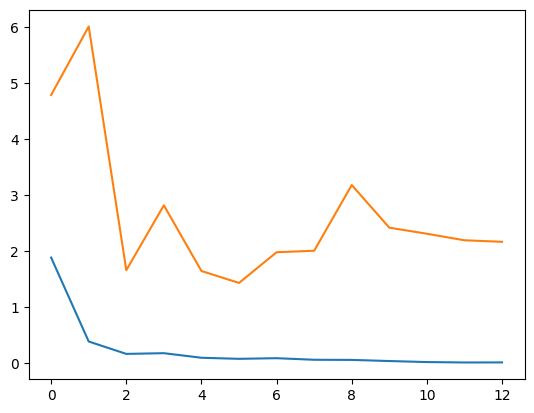

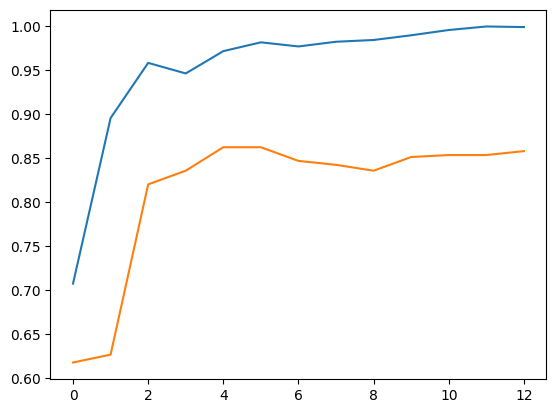

In [49]:
plot_history(history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step


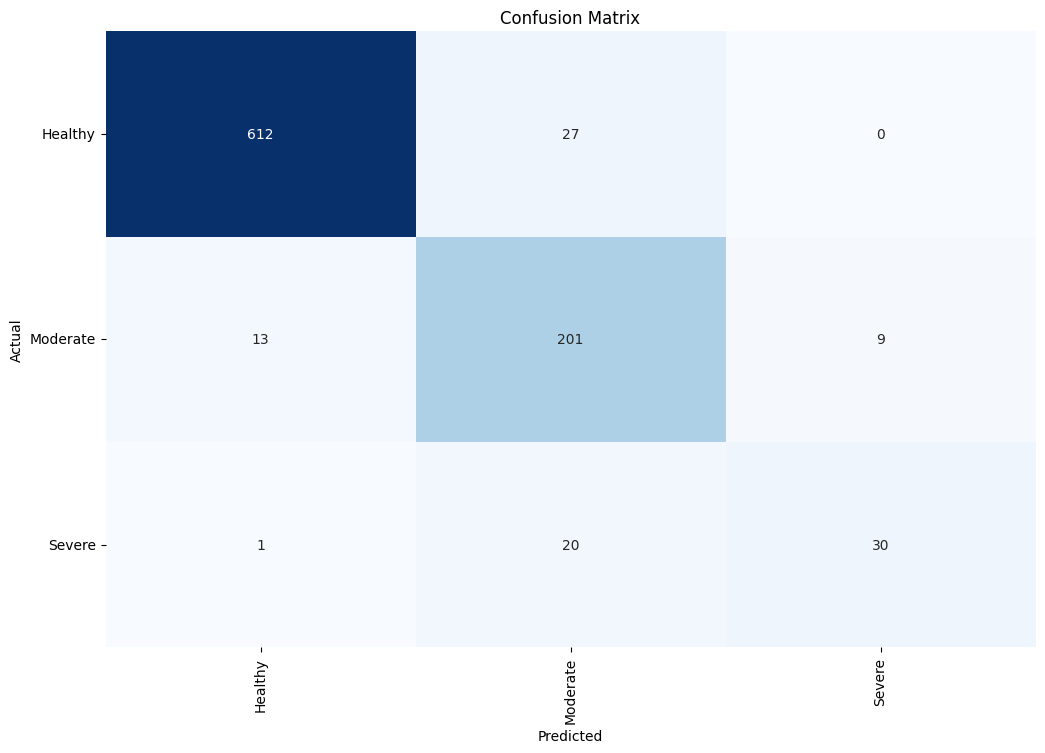

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9776    0.9577    0.9676       639
    Moderate     0.8105    0.9013    0.8535       223
      Severe     0.7692    0.5882    0.6667        51

    accuracy                         0.9233       913
   macro avg     0.8525    0.8158    0.8293       913
weighted avg     0.9252    0.9233    0.9229       913



In [50]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

### ResNet50V2 - 3 klase

In [89]:
img_size = 224

In [90]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [91]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [92]:
tmp_folder = os.path.join(root_folder, 'ResNet50V2_3class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [93]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [83]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4650 - loss: 3.9250
Epoch 1: val_loss improved from inf to 2.61641, saving model to ../ResNet50V2_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.4658 - loss: 3.9131 - val_accuracy: 0.6067 - val_loss: 2.6164 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6720 - loss: 1.7007
Epoch 2: val_loss improved from 2.61641 to 2.30688, saving model to ../ResNet50V2_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.6721 - loss: 1.6986 - val_accuracy: 0.6489 - val_loss: 2.3069 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7673 - loss: 1.0469
Epoch 3: val_loss improved from 2.30688 to 1.87197, saving model to ../ResNet50V2_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.7674 - loss: 1.0469 - val_accuracy: 0.7333 - val_loss: 1.8720 - learning_rate: 0.0010
Epoch 4/

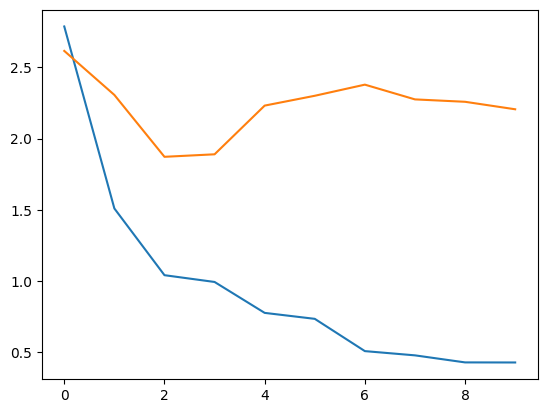

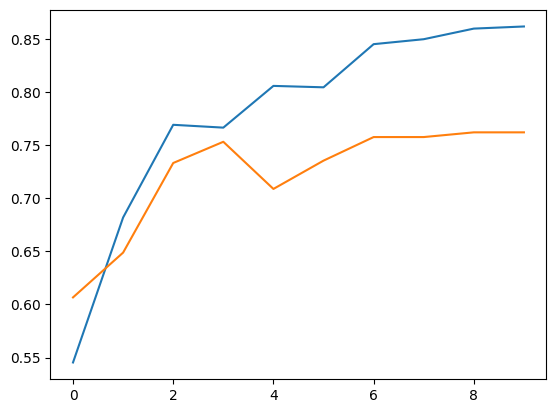

In [84]:
plot_history(history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step


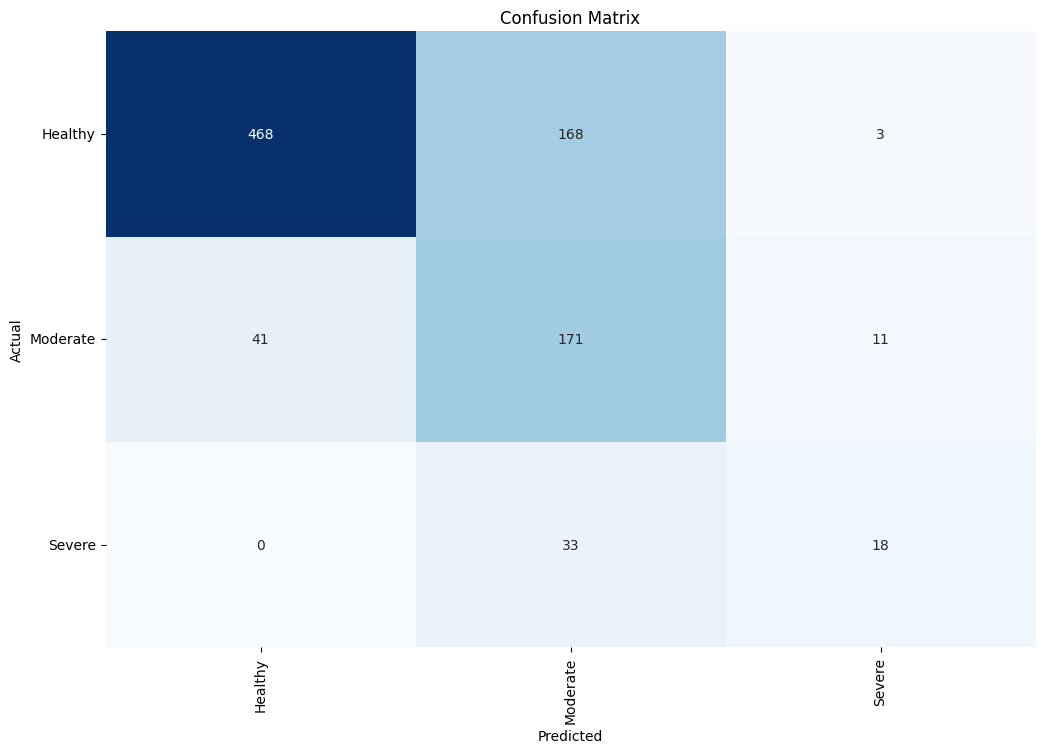

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9194    0.7324    0.8153       639
    Moderate     0.4597    0.7668    0.5748       223
      Severe     0.5625    0.3529    0.4337        51

    accuracy                         0.7196       913
   macro avg     0.6472    0.6174    0.6080       913
weighted avg     0.7872    0.7196    0.7353       913



In [95]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

#### Full

In [96]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [97]:
tmp_folder = os.path.join(root_folder, 'ResNet50V2_3class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [98]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [41]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5073 - loss: 4.4767
Epoch 1: val_loss improved from inf to 35.05415, saving model to ../ResNet50V2_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 632s 6s/step - accuracy: 0.5078 - loss: 4.4589 - val_accuracy: 0.3644 - val_loss: 35.0541 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6471 - loss: 1.1666
Epoch 2: val_loss improved from 35.05415 to 3.57982, saving model to ../ResNet50V2_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 586s 6s/step - accuracy: 0.6475 - loss: 1.1652 - val_accuracy: 0.5311 - val_loss: 3.5798 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6848 - loss: 0.8258
Epoch 3: val_loss did not improve from 3.57982
94/94 ━━━━━━━━━━━━━━━━━━━━ 547s 6s/step - accuracy: 0.6850 - loss: 0.8266 - val_accuracy: 0.6222 - val_loss: 41.9600 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7417 - lo

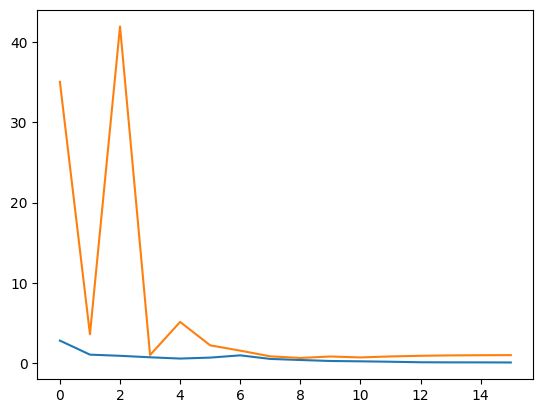

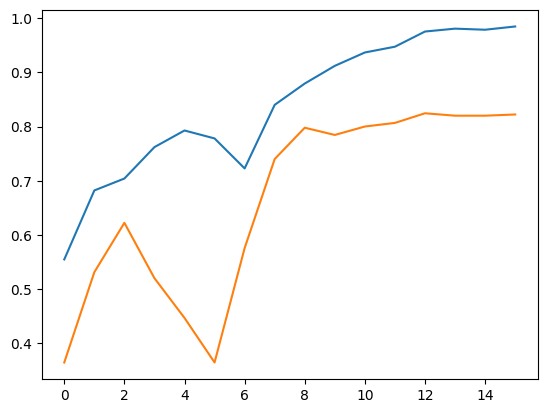

In [42]:
plot_history(history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step


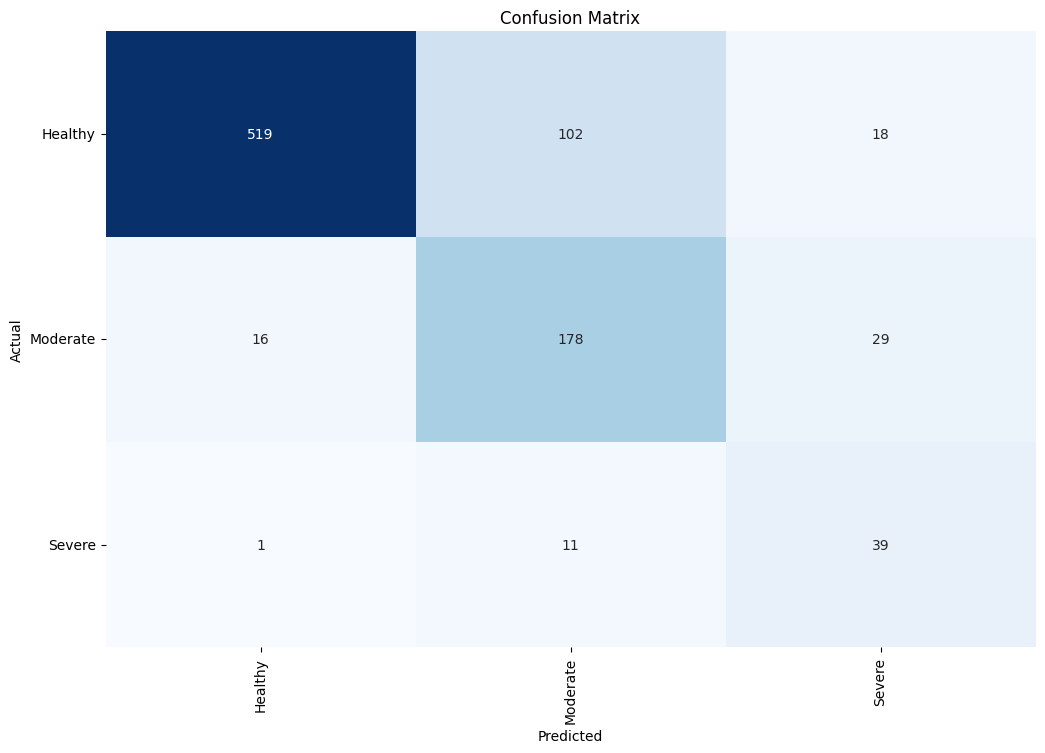

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9683    0.8122    0.8834       639
    Moderate     0.6117    0.7982    0.6926       223
      Severe     0.4535    0.7647    0.5693        51

    accuracy                         0.8061       913
   macro avg     0.6778    0.7917    0.7151       913
weighted avg     0.8524    0.8061    0.8193       913



In [100]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

### NASNetMobile - 3 klase

In [101]:
img_size = 224

In [102]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [103]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.nasnet.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [104]:
tmp_folder = os.path.join(root_folder, 'NASNetMobile_3class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [105]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [49]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.4389 - loss: 2.4253
Epoch 1: val_loss improved from inf to 1.33721, saving model to ../NASNetMobile_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 114s 826ms/step - accuracy: 0.4398 - loss: 2.4179 - val_accuracy: 0.5844 - val_loss: 1.3372 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.6141 - loss: 1.1234
Epoch 2: val_loss improved from 1.33721 to 1.28487, saving model to ../NASNetMobile_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 744ms/step - accuracy: 0.6143 - loss: 1.1231 - val_accuracy: 0.5956 - val_loss: 1.2849 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.6700 - loss: 1.0199
Epoch 3: val_loss did not improve from 1.28487
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 716ms/step - accuracy: 0.6700 - loss: 1.0199 - val_accuracy: 0.5889 - val_loss: 1.3914 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/ste

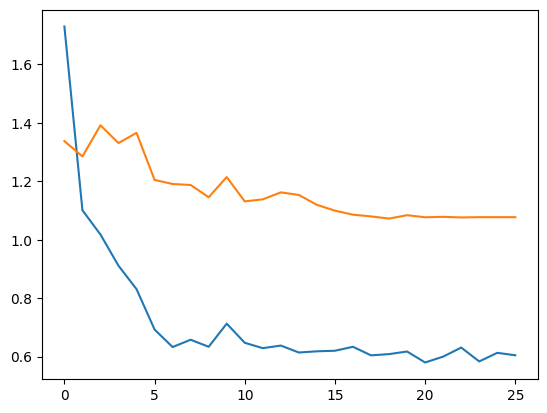

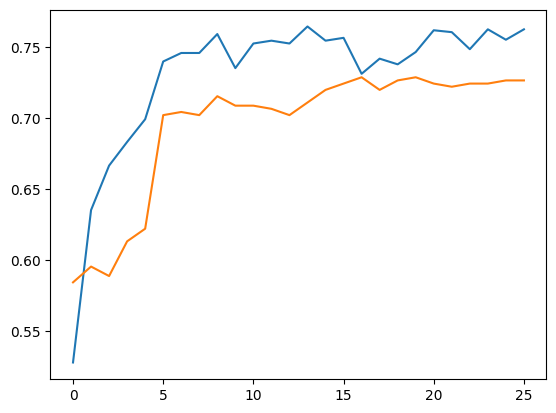

In [50]:
plot_history(history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 64s 925ms/step


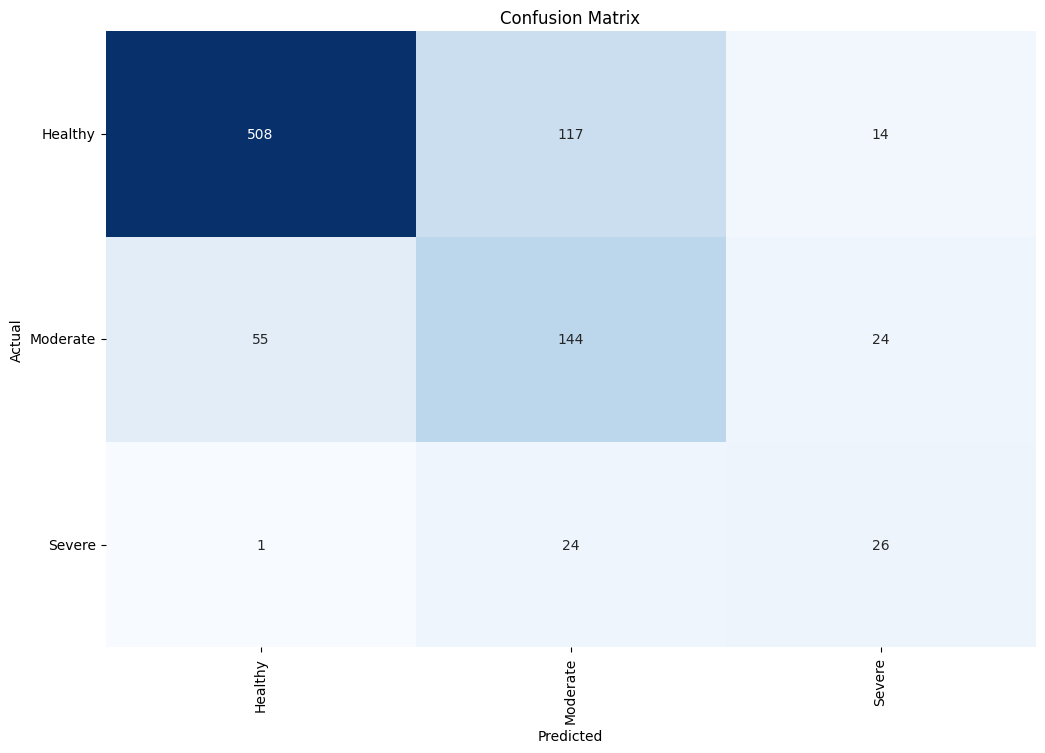

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9007    0.7950    0.8446       639
    Moderate     0.5053    0.6457    0.5669       223
      Severe     0.4062    0.5098    0.4522        51

    accuracy                         0.7426       913
   macro avg     0.6041    0.6502    0.6212       913
weighted avg     0.7765    0.7426    0.7548       913



In [107]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

#### Full

In [108]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.nasnet.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [109]:
tmp_folder = os.path.join(root_folder, 'NASNetMobile_3class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [110]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [57]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5858 - loss: 2.4570
Epoch 1: val_loss improved from inf to 6.06091, saving model to ../NASNetMobile_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.5866 - loss: 2.4481 - val_accuracy: 0.3733 - val_loss: 6.0609 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7959 - loss: 0.5682
Epoch 2: val_loss improved from 6.06091 to 4.04898, saving model to ../NASNetMobile_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.7965 - loss: 0.5666 - val_accuracy: 0.4111 - val_loss: 4.0490 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8963 - loss: 0.2679
Epoch 3: val_loss improved from 4.04898 to 3.00162, saving model to ../NASNetMobile_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.8965 - loss: 0.2676 - val_accuracy: 0.4956 - val_loss: 3.0016 - learning_rate: 0.0010
Epoch 4/30


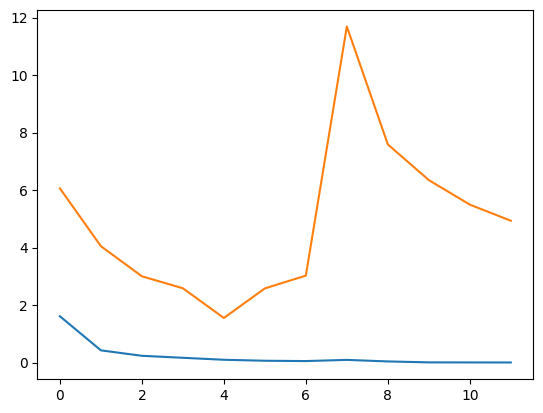

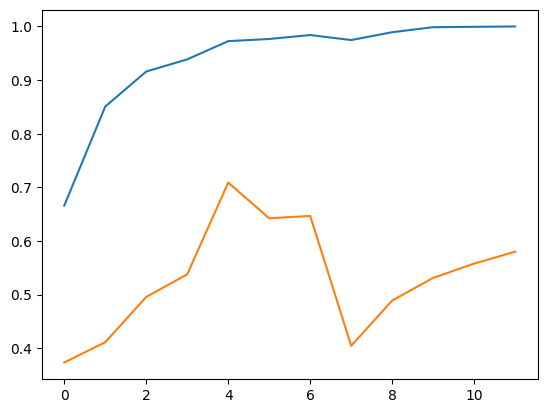

In [60]:
plot_history(history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 66s 963ms/step


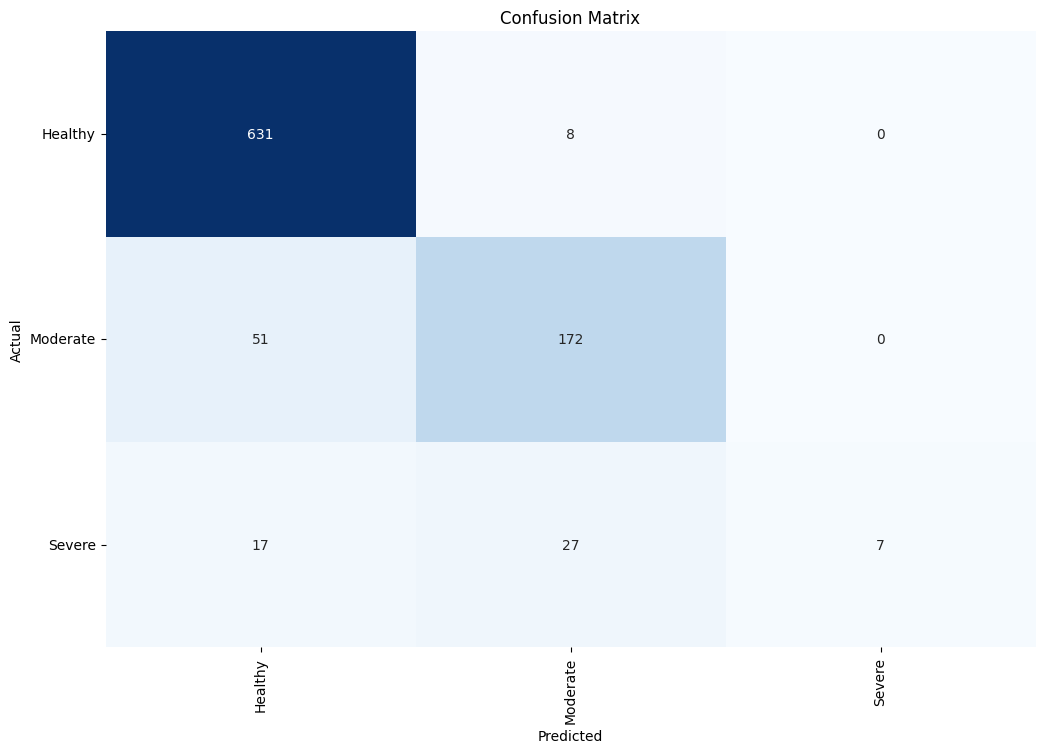

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9027    0.9875    0.9432       639
    Moderate     0.8309    0.7713    0.8000       223
      Severe     1.0000    0.1373    0.2414        51

    accuracy                         0.8872       913
   macro avg     0.9112    0.6320    0.6615       913
weighted avg     0.8906    0.8872    0.8690       913



In [112]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

### XCeption - 3 klase

In [113]:
img_size = 299

In [114]:
x_train, y_train = prepare_data(train_df, img_size)
x_test, y_test = prepare_data(test_df, img_size)
x_valid, y_valid = prepare_data(valid_df, img_size)

#### Softmax

In [115]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.xception.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = False

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [116]:
tmp_folder = os.path.join(root_folder, 'XCeption_3class_softmax')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [117]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [40]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5474 - loss: 1.0227
Epoch 1: val_loss improved from inf to 0.93681, saving model to ../XCeption_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - accuracy: 0.5483 - loss: 1.0205 - val_accuracy: 0.6000 - val_loss: 0.9368 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6886 - loss: 0.6810
Epoch 2: val_loss improved from 0.93681 to 0.79150, saving model to ../XCeption_3class_softmax\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.6888 - loss: 0.6806 - val_accuracy: 0.6867 - val_loss: 0.7915 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7595 - loss: 0.5569
Epoch 3: val_loss did not improve from 0.79150
94/94 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - accuracy: 0.7596 - loss: 0.5567 - val_accuracy: 0.7178 - val_loss: 0.8287 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7774 - loss

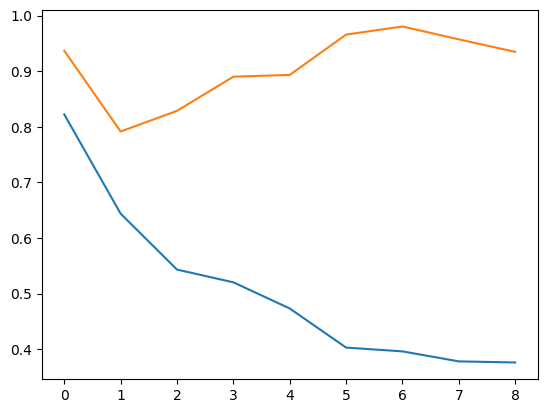

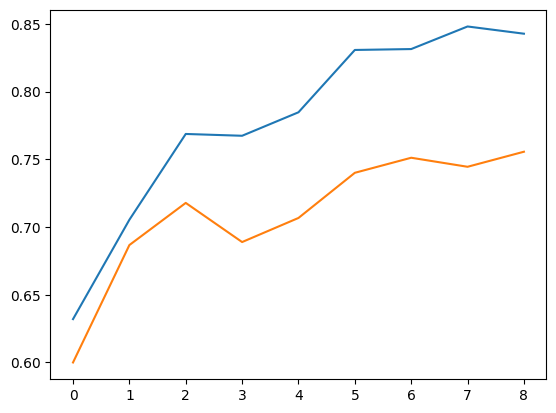

In [41]:
plot_history(history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step


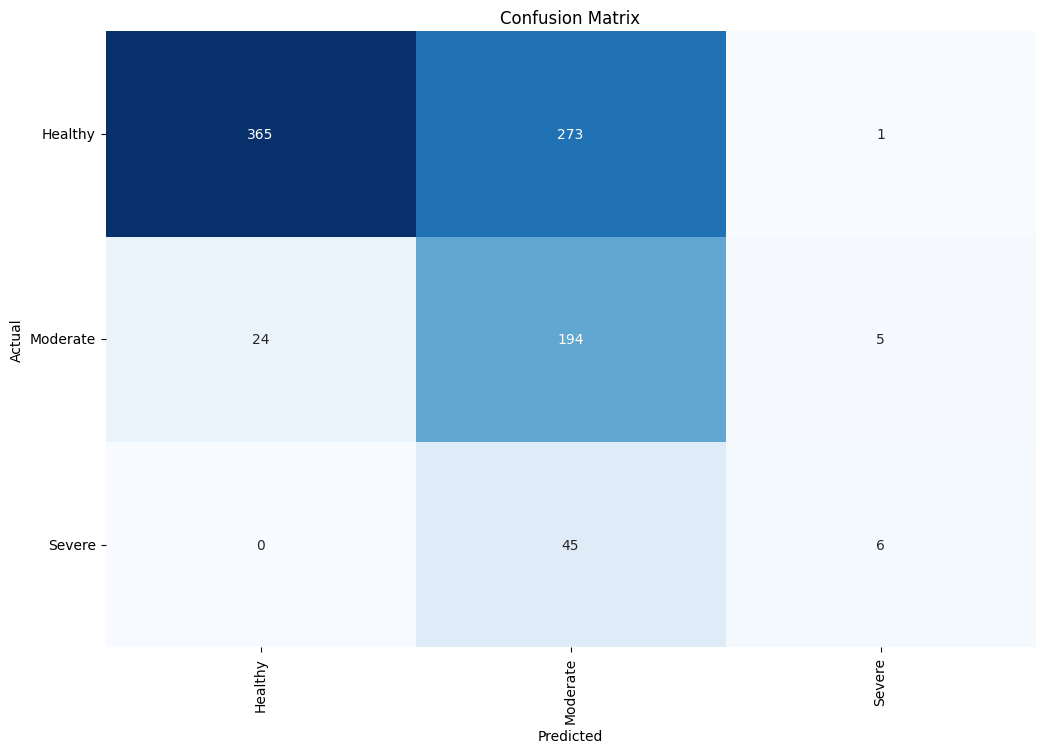

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9383    0.5712    0.7101       639
    Moderate     0.3789    0.8700    0.5279       223
      Severe     0.5000    0.1176    0.1905        51

    accuracy                         0.6188       913
   macro avg     0.6057    0.5196    0.4762       913
weighted avg     0.7772    0.6188    0.6366       913



In [119]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)

#### Full

In [120]:
@register_keras_serializable(package='Custom', name='preprocess_input')
def preprocess_input(*args, **kwargs):
    return tf.keras.applications.xception.preprocess_input(*args, **kwargs)

img_shape = (img_size, img_size, 3)

x = tf.keras.layers.Input(shape=img_shape, name='input')

y = tf.keras.layers.Lambda(preprocess_input, name='adjust_input')(x)

base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                                input_tensor=y, pooling='max')

base_model.trainable = True

y = base_model.output

y = Dropout(rate=.2, seed=123)(y)       

output = Dense(class_count, activation='softmax')(y)

model = Model(inputs=x, outputs=output)

model.compile(Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [121]:
tmp_folder = os.path.join(root_folder, 'XCeption_3class_full')
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

In [122]:
path = os.path.join(tmp_folder, 'model.keras')
callbacks = create_callbacks(tmp_folder, path)

In [46]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,  
                  validation_data=(x_valid, y_valid),
                  validation_steps=None,  shuffle=False)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6559 - loss: 0.9451 
Epoch 1: val_loss improved from inf to 2.89013, saving model to ../XCeption_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1707s 17s/step - accuracy: 0.6568 - loss: 0.9420 - val_accuracy: 0.7422 - val_loss: 2.8901 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8378 - loss: 0.4502 
Epoch 2: val_loss improved from 2.89013 to 2.26270, saving model to ../XCeption_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1561s 17s/step - accuracy: 0.8380 - loss: 0.4496 - val_accuracy: 0.8467 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9057 - loss: 0.3036 
Epoch 3: val_loss improved from 2.26270 to 0.72266, saving model to ../XCeption_3class_full\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1548s 16s/step - accuracy: 0.9058 - loss: 0.3032 - val_accuracy: 0.8667 - val_loss: 0.7227 - learning_rate: 0.0010
Epoch 4/30


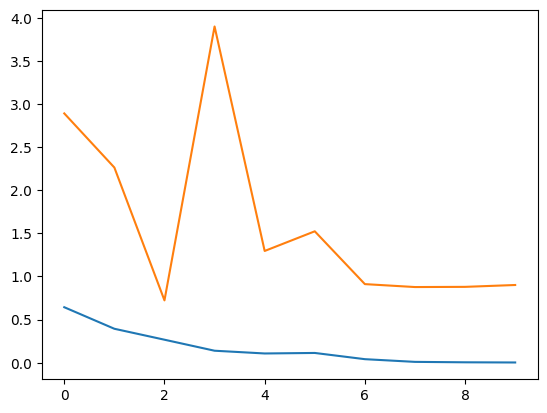

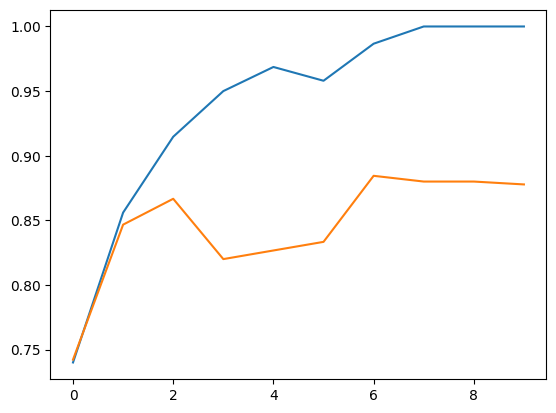

In [47]:
plot_history(history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step


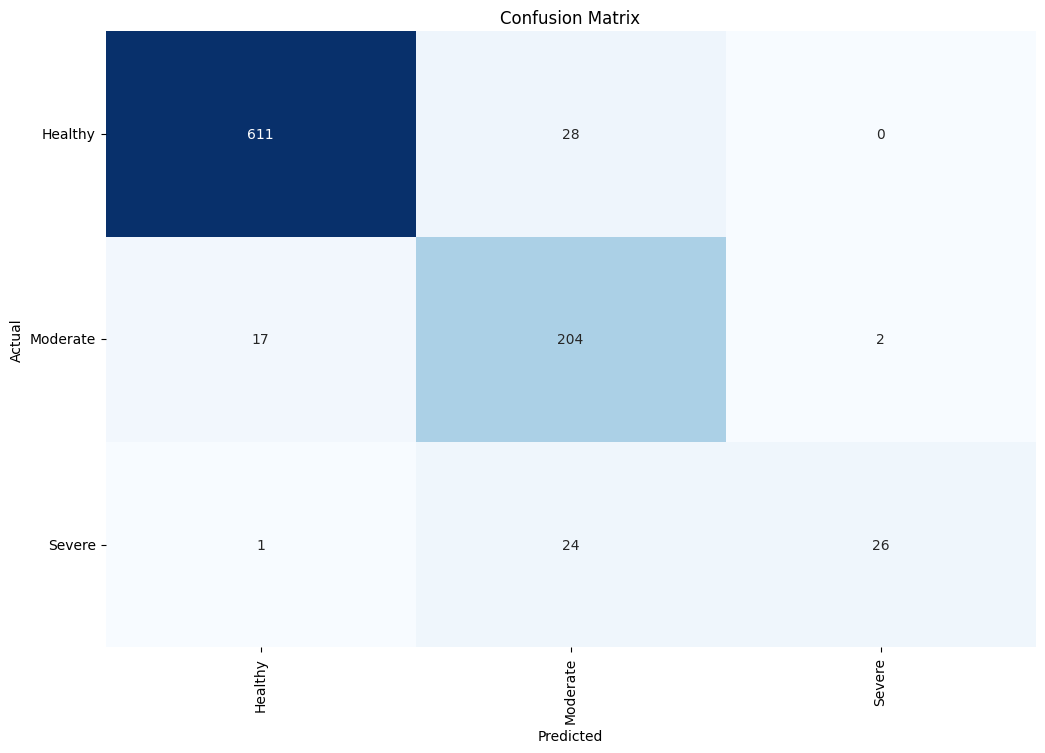

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9714    0.9562    0.9637       639
    Moderate     0.7969    0.9148    0.8518       223
      Severe     0.9286    0.5098    0.6582        51

    accuracy                         0.9211       913
   macro avg     0.8989    0.7936    0.8246       913
weighted avg     0.9264    0.9211    0.9193       913



In [124]:
evaluate(model, batch_size, x_test, y_test, list_of_classes)